In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
%pip install azure-storage-blob

     |████████████████████████████████| 348kB 6.0MB/s 
     |████████████████████████████████| 92kB 4.8MB/s 
     |████████████████████████████████| 133kB 9.2MB/s 
     |████████████████████████████████| 2.6MB 9.5MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 


In [3]:
import os, uuid
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, __version__

try:
    print("Azure Blob storage v" + __version__ + " - Python quickstart sample")
    # Quick start code goes here
except Exception as ex:
    print('Exception:')
    print(ex)

Azure Blob storage v12.7.1 - Python quickstart sample


In [4]:
def to_bw(c):
    a = c.astype(np.float)
    b = np.zeros(a.shape)
    for x in range(a.shape[0]):
        for y in range(a.shape[1]):
            t = np.float(a[x][y][0] + a[x][y][1] + a[x][y][2])/765
            b[x][y][0] = t
            b[x][y][1] = t
            b[x][y][2] = t
    return b

In [17]:
STORAGEACCOUNTNAME= "hpegoal"
STORAGEACCOUNTKEY= "GO0LxLX+2O/yfNaOAe9lbENXe71828ywoh3Yo4vkqW8WKdlL4RdLrhXbcgg1p/wJKYYpNMf712nQPkLYjeRKUA=="
LOCALFILENAME= "0"
CONTAINERNAME= "train"
local_file_name = "0.mp4"

In [18]:
 connect_str  = 'DefaultEndpointsProtocol=https;AccountName=hpegoal;AccountKey=GO0LxLX+2O/yfNaOAe9lbENXe71828ywoh3Yo4vkqW8WKdlL4RdLrhXbcgg1p/wJKYYpNMf712nQPkLYjeRKUA==;EndpointSuffix=core.windows.net'
!pwd

/content


In [19]:
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [20]:
blob_client = blob_service_client.get_blob_client(container=CONTAINERNAME, blob=local_file_name)

In [21]:
blob_client.get_blob_properties()

{'name': '0.mp4', 'container': 'train', 'snapshot': None, 'version_id': None, 'is_current_version': None, 'blob_type': <BlobType.BlockBlob: 'BlockBlob'>, 'metadata': {}, 'encrypted_metadata': None, 'last_modified': datetime.datetime(2021, 1, 26, 7, 5, 30, tzinfo=datetime.timezone.utc), 'etag': '"0x8D8C1C8C447BF98"', 'size': 229865386, 'content_range': None, 'append_blob_committed_block_count': None, 'is_append_blob_sealed': None, 'page_blob_sequence_number': None, 'server_encrypted': True, 'copy': {'id': None, 'source': None, 'status': None, 'progress': None, 'completion_time': None, 'status_description': None, 'incremental_copy': None, 'destination_snapshot': None}, 'content_settings': {'content_type': 'video/mp4', 'content_encoding': None, 'content_language': None, 'content_md5': None, 'content_disposition': None, 'cache_control': None}, 'lease': {'status': 'unlocked', 'state': 'available', 'duration': None}, 'blob_tier': 'Hot', 'rehydrate_priority': None, 'blob_tier_change_time': No

In [22]:
with open("./sample.mp4", "wb") as my_blob:
    blob_data = blob_client.download_blob()
    blob_data.readinto(my_blob)

In [23]:
import matplotlib.pyplot as plt
import imageio

In [24]:
video_file = '/content/sample.mp4'
vid = imageio.get_reader(video_file, 'ffmpeg')

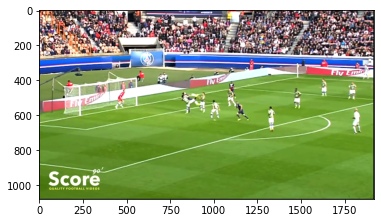

In [33]:
sec = 74
frame = vid.get_data(30*sec)
plt.imshow(frame)

In [50]:
frame_1 = (frame>200) * frame
frame_1.shape

(1080, 1920, 3)

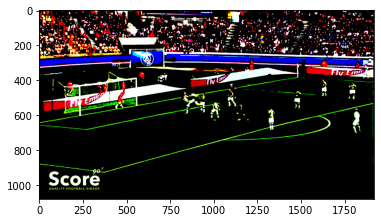

In [51]:
plt.imshow(frame_1)

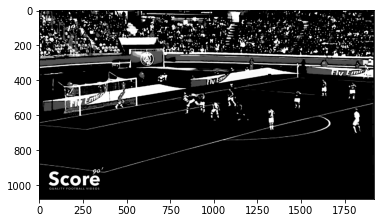

In [52]:
frame_bw = to_bw(frame_1)
plt.imshow(frame_bw)